## Deep Knowledge Tracing

We will try out three different deep learning models. The code is in the folder DeepModels.

# Data

We will fit data from the Assistments platform (https://www.commonsense.org/education/website/assistments). These data are from the course 2009.

First make sure to download the data from https://drive.google.com/file/d/1AWbYGz84WHpC6UbO6PHBkBnPKpSTJPEZ/view?usp=sharing to the folder **./DeepModels/datasets/ASSIST2009/**. The data preparation script assumes that the data are in a file **./DeepModels/datasets/ASSIST2009/skill_builder_data.csv**.

In [1]:
# Install and import
!pip install torch

import os
import pandas as pd
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# If running on colab, clone the repo
# # !git clone https://github.com/benjamingarzon/AMLD2025-Education-Workshop.git
# %cd AMLD2025-Education-Workshop


In [3]:
os.makedirs("DeepModels/datasets/ASSIST2009", exist_ok=True)

Inspect the data:
- *user_id* - Student ID. 
- *log_id* - Indicates the order in which it was presented.
- *sequence_id* - Knowledge Component (KC). Groups items (exercises/questions) of a similar topic or skill.
- *correct* - Whether the response is correct (1) or incorrect (0).

In [4]:
data_dir = "DeepModels/datasets/ASSIST2009"
data = pd.read_csv(
    os.path.join(data_dir, "skill_builder_data.csv"),
    sep=",",
)

print(data.head(10))
print(data.user_id.nunique())
print(data.shape)
print(data.correct.value_counts())

   Unnamed: 0  order_id  assignment_id  user_id  assistment_id  problem_id  \
0           1  33022537         277618    64525          33139       51424   
1           2  33022709         277618    64525          33150       51435   
2           3  35450204         220674    70363          33159       51444   
3           4  35450295         220674    70363          33110       51395   
4           5  35450311         220674    70363          33196       51481   
5           6  35450555         220674    70363          33172       51457   
6           7  35450573         220674    70363          33174       51459   
7           8  35480603         220674    70363          33123       51408   
8           9  33140811         220674    70677          33168       51453   
9          10  33140919         220674    70677          33112       51397   

   original  correct  attempt_count  ms_first_response  ... hint_count  \
0         1        1              1              32454  ...        

# Preprocessing

Since datasets can differ in how they are formatted. In the **data_loaders** folder there are preprocessing scripts. These are called when you run the model (no need to call them separately). We can run *train.py* with the option *--only_preprocess* to run only the preprocessing, to avoid a long wait. 

In [5]:
os.chdir("DeepModels/")

In [6]:
!python train.py --model_name=dkt --dataset_name=ASSIST2009 --only_preprocess 

c:\Users\benja\anaconda3\envs\AMLDAIEd\Lib\site-packages\torch\__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)


Briefly, the preprocessing implements the following steps (see train.py and data_loaders/assist2009.py):

- Sort responses by log_id (time) for each student.
- Remove observations if correct is different from 1 or 0.
- Reindex students and items (consecutive indices starting from 0).
- Split sequences of KCs and responses so that they have uniform length (*seq_len*).
- Split dataset in train and test (e.g., 90%/10%).

The preprocessing creates the following files that are used to train the model:

*u_list.pkl*: List of student ids.
*u2idx.pkl*: Dict with mapping of student ids to indices.

*q_list.pkl*: List of knowledge component (KC) ids.
*q2idx.pkl*: Dict with mapping of KC ids to indices.

*r_seqs.pkl*: List of sequences of responses. Each element is an array that corresponds to the sequence of responses of one student, ordered by timestamp (log_id).
*q_seqs.pkl*: List of sequences of KCs. Each element is an array that corresponds to the sequence of KCs of one student, ordered by timestamp (log_id). It matches r_seqs.

*train_indices.pkl*, *test_indices.pkl*: training/test indices

Inspect these files:

In [7]:
data_dir = "./datasets/ASSIST2009"
pkl_files = [f for f in os.listdir(data_dir) if f.endswith(".pkl")]


data_dict = {}


for file in pkl_files:

    with open(os.path.join(data_dir, file), "rb") as f:
        data_dict[os.path.splitext(file)[0]] = pickle.load(f)


print(data_dict["u_list"][:5])
print(data_dict["q_list"][:5])


print(data_dict["q_seqs"][:5])


print(data_dict["r_seqs"][:5])

print(len(data_dict["train_indices"]))
print(len(data_dict["test_indices"]))

[   14 21825 51950 52613 53167]
['Absolute Value' 'Addition Whole Numbers'
 'Addition and Subtraction Fractions' 'Addition and Subtraction Integers'
 'Addition and Subtraction Positive Decimals']
[array([18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 45, 70, 70, 45, 70,
       45, 45]), array([90, 90, 90, 90, 90, 90, 90, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48]), array([30, 30, 30, 30, 29, 29]), array([ 4, 33, 51, 25, 25, 25]), array([ 4,  4,  4,  4,  3,  3, 48, 48, 21, 77, 48, 47,  3,  2,  2,  2,  2,
        2,  1,  1,  1,  2,  4, 48,  2,  2,  4, 55, 56, 48, 52, 52, 52, 84,
       89, 89, 89, 89, 50, 16, 90, 90, 66, 66, 90, 90, 90, 90, 90, 90, 22,
       87,  1,  1, 87, 56, 54, 67, 55, 30, 30, 30, 30, 30, 30, 30, 30, 24,
       20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 90, 90, 90, 16,  9,  9,
        9,  9,  9,  1,  1,  3,  3,  3,  3,  4,  2,  2,  1,  1,  1,  1,  1,
       56, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 92, 92, 92, 92, 92, 92,
       60, 60, 60, 60, 60, 49, 49, 49, 49, 

*q_seqs*, *r_seqs* are finally converted in datasets which consists of pairs *(q, r)*, where *q* and *r* are 1-d arrays. *q* is a sequence of KC indices and *r* a sequence of responses (0 or 1). The sequences have length *seq_len* and are padded at the end with -1. 

# Configuration

The configuration file config.json allows to specify parameters for the training and for the different models. 

In [8]:
with open("config.json", "r") as f:
    print(f.read())

{
    "train_config": {
        "batch_size": 256,
        "num_epochs": 100,
        "train_ratio": 0.9,
        "learning_rate": 0.001,
        "optimizer": "adam",
        "seq_len": 100
    },
    "dkt": {
        "emb_size": 30,
        "hidden_size": 30
    },
    "dkvmn": {
        "dim_s": 50,
        "size_m": 20
    },
    "sakt": {
        "n": 100,
        "d": 100,
        "num_attn_heads": 5,
        "dropout": 0.2
    }
}


# Fitting the model

Now you can fit a model. Here are there are three possibilities: Deep Knowledge Tracing (**dkt**, https://arxiv.org/abs/1506.05908), Dynamic Key-Value Memory Networks (**dkvmn**, https://arxiv.org/abs/1611.08108), and Self-Attentive Knowledge Tracing (**sakt**, https://arxiv.org/abs/1907.06837). After running it, results (loss and aucs) for the test set can be found in the folder *ckpts*. You can see the code for these models in the folder **./models**.

In [9]:
# model_name can be dkt, dkvmn or sakt
!python train.py --model_name=dkt --dataset_name=ASSIST2009

torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([65, 100])
Epoch: 1,   AUC: 0.5980299145951871,   Loss Mean: 0.6867358088493347
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([256, 100])
torch.Size([

c:\Users\benja\anaconda3\envs\AMLDAIEd\Lib\site-packages\torch\__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)
g:\My Drive\Supervision\AMLD-workshop\AMLD2024-Education-Workshop\DeepModels\models\utils.py:91: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:80.)
  q_seqs.append(FloatTensor(q_seq[:-1]))


Since this takes a while to run, you have the precomputed results for three models (dkt, dkvmn, sakt) in the folder *ckpts_precomputed/[model_name]/[dataset_name]*. Mind that you would need to tune the hyperparameters of the models and implement early stopping using a validation dataset for each of the models if you wanted to compare them, but this would require multiple runs.

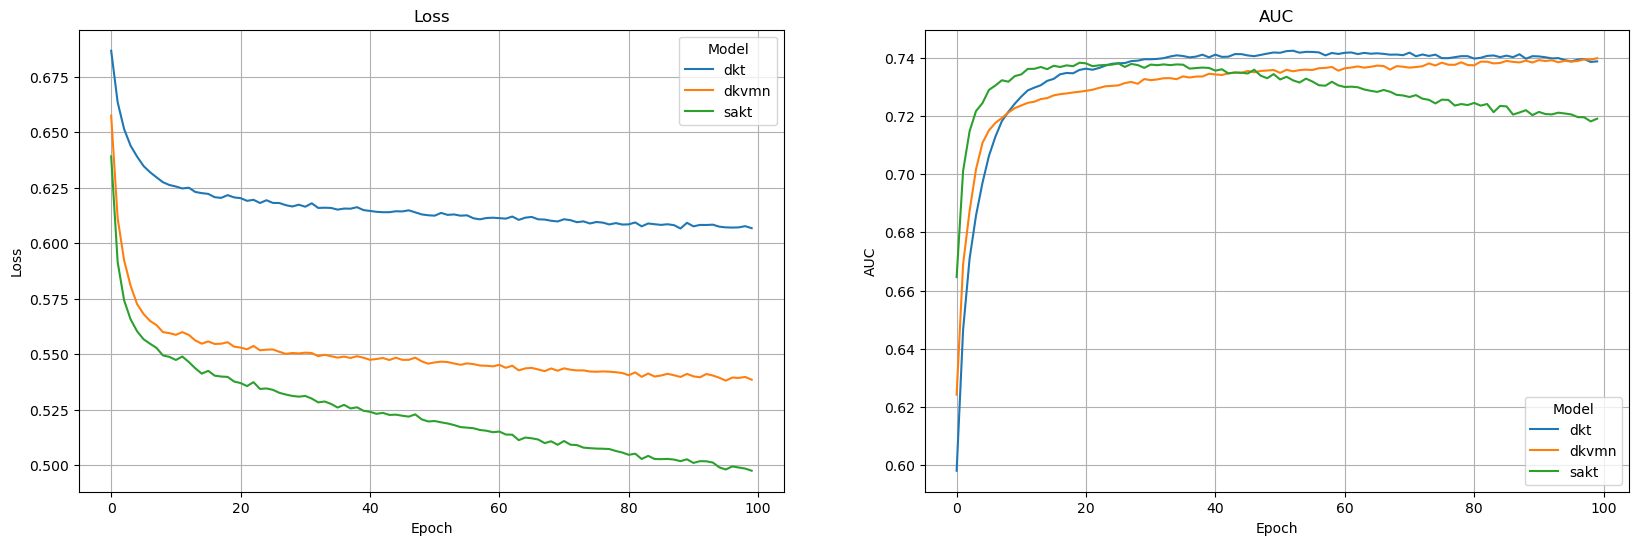

In [10]:
results_dict = {}
combined_df = None
for model_name in ["dkt", "dkvmn", "sakt"]:
    ckpt_dir = f"ckpts/{model_name}/ASSIST2009"

    if not os.path.exists(ckpt_dir):
        continue

    pkl_files = [f for f in os.listdir(ckpt_dir) if f.endswith(".pkl")]

    if len(pkl_files) == 0:
        continue

    results_dict[model_name] = {}

    for file in pkl_files:
        with open(os.path.join(ckpt_dir, file), "rb") as f:
            results_dict[model_name][os.path.splitext(file)[0]] = pickle.load(f)

    # Create DataFrames for plotting
    df = pd.DataFrame(
        {
            "Epoch": range(len(results_dict[model_name]["aucs"])),
            "AUC": results_dict[model_name]["aucs"],
            "Loss": results_dict[model_name]["loss_means"],
            "Model": model_name,
        }
    )

    if combined_df is None:
        combined_df = df
    else:
        combined_df = pd.concat([combined_df, df])

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot Loss
sns.lineplot(ax=axes[0], data=combined_df, x="Epoch", y="Loss", hue="Model")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True)

# Plot AUC
sns.lineplot(ax=axes[1], data=combined_df, x="Epoch", y="AUC", hue="Model")
axes[1].set_title("AUC")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("AUC")
axes[1].grid(True)

plt.show()